
# Module 4 Session 2 - Quantifying Health Disparities

## Authors: Shivam Sharma & Vincent Lam 

#### Date: May 29, 2024


## Section 1 - Data exploration

In [2]:
rm(list=ls())
set.seed(13)

library("data.table")
library("dplyr")
library("parallel")
library('stringr')
library('ggplot2')


options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 120)

In [3]:
# Load the files for our cohort.
cohort = as.data.frame(fread("../Data/Session2/ParticipantCohort.tsv"))
dim(cohort)
head(cohort)

ehr_records = as.data.frame(fread("../Data/Session2/ParticipantEHR.tsv"))
dim(ehr_records)
head(ehr_records)

[1] 50000     4

,ParticipantID,Age,Sex,SIRE
,<int>,<dbl>,<chr>,<chr>
1,474883,18.50098,F,Black
2,989029,18.00000,F,Black
3,590541,21.44716,F,Black
4,377776,24.45020,F,Black
5,330372,20.64606,F,Black
6,758008,23.00696,F,Black


[1] 500037      2

,ParticipantID,ICD10CM
,<int>,<chr>
1,474883,M05.31
2,474883,Q72
3,474883,S28.22
4,474883,S93.103S
5,474883,T36.7X2A
6,474883,S82.115M


In [4]:
#Explore the data a little bit.
cohort %>% count(SIRE, Sex)
cohort %>% group_by(SIRE, Sex) %>% summarize(MeanAge = mean(Age))

SIRE,Sex,n
<chr>,<chr>,<int>
Black,F,4670
Black,M,2759
Hispanic,F,7436
Hispanic,M,2990
White,F,20314
White,M,11831


`summarise()` has grouped output by 'SIRE'. You can override using the `.groups` argument.


SIRE,Sex,MeanAge
<chr>,<chr>,<dbl>
Black,F,48.04122
Black,M,47.88016
Hispanic,F,50.08872
Hispanic,M,50.05681
White,F,46.27746
White,M,46.37888


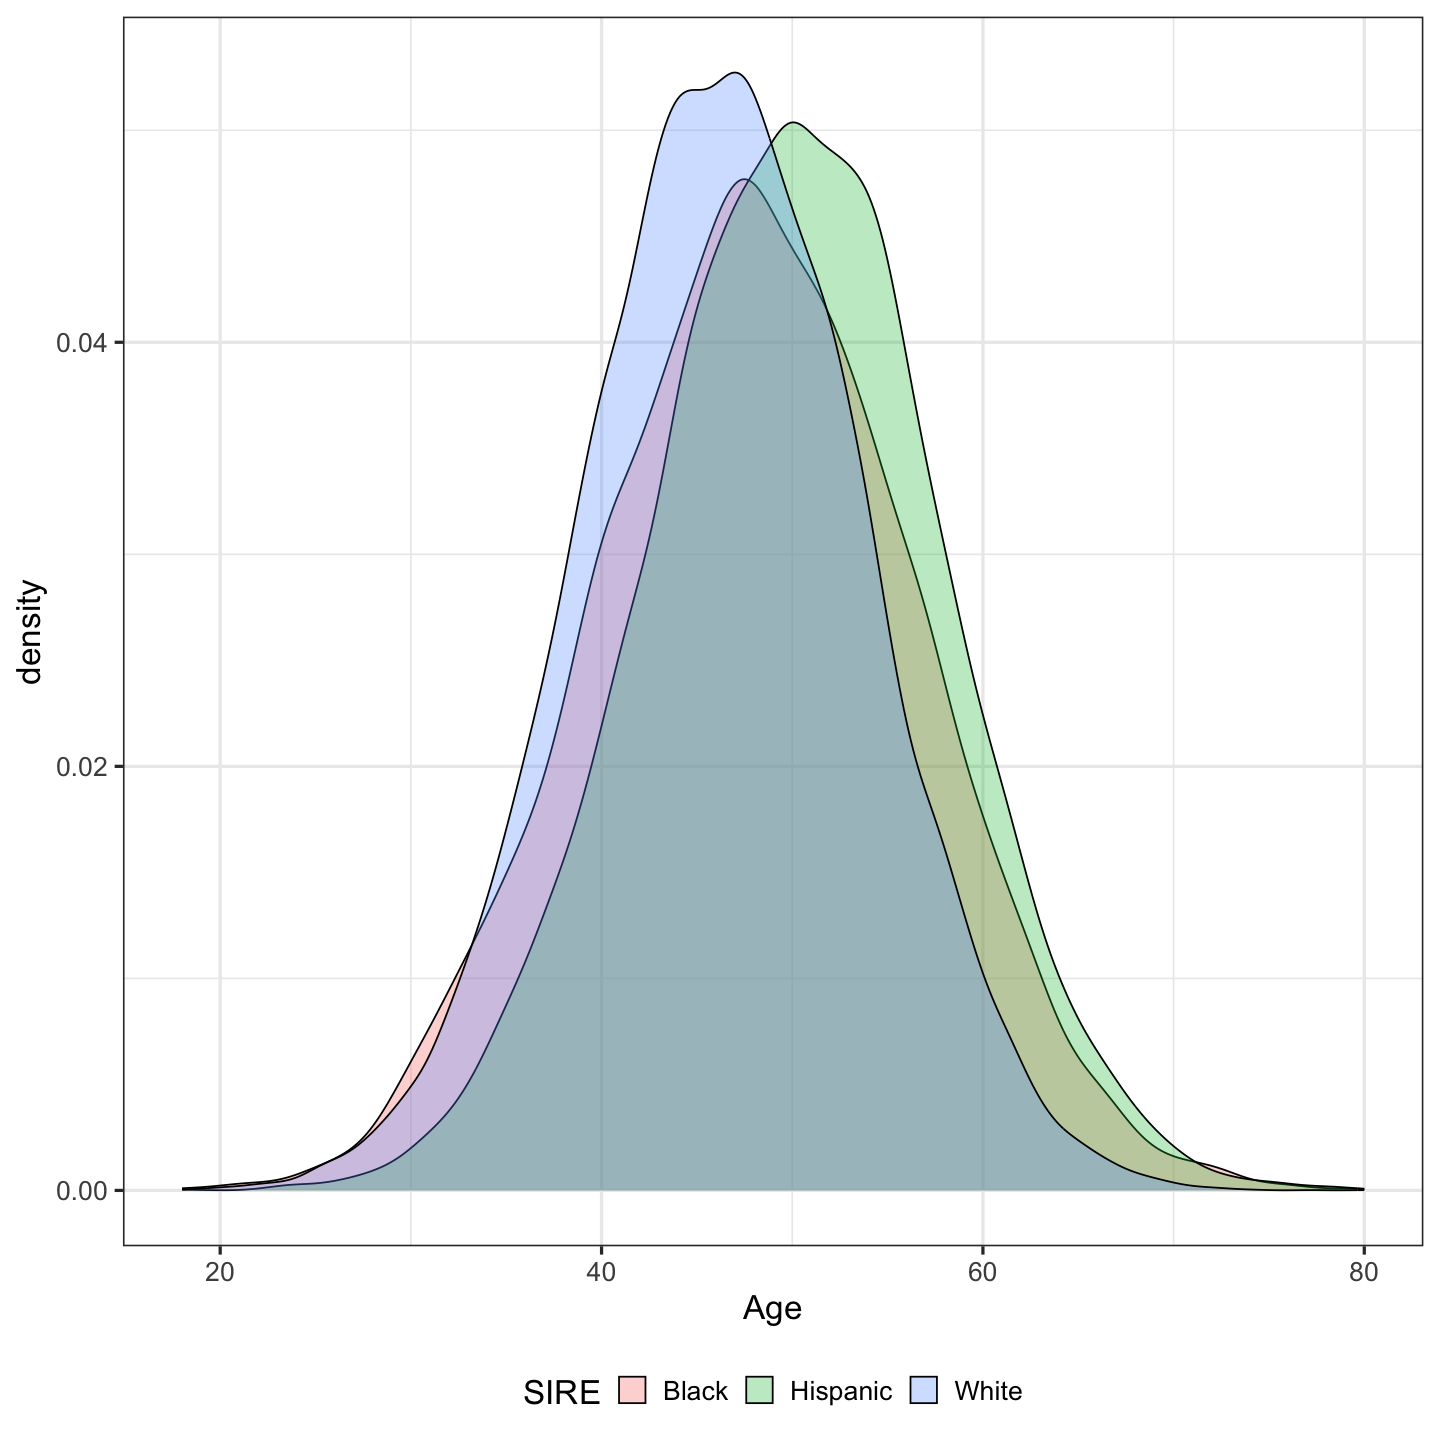

In [5]:
# Visualzie the density of age distribution.
ggplot(cohort, aes(x = Age, fill = SIRE)) + 
    geom_density(alpha = 0.3) + 
    theme_bw(base_size = 20) + 
    theme(legend.position = "bottom")

In [6]:
#Let's have a look at the EHR records.
print("Number of rows in our EHR df: ")
dim(ehr_records)

#See the number of people in the EHR data.
print("Number of participants that have EHR records: ")
length(unique(ehr_records$ParticipantID))

print("Number of unique EHR records: ")
length(unique(ehr_records$ICD10CM))


[1] "Number of rows in our EHR df: "


[1] 500037      2

[1] "Number of participants that have EHR records: "


[1] 50000

[1] "Number of unique EHR records: "


[1] 47693

## Section 2 - Create case-control cohorts

In [7]:
# Read the phecode map for ICD10CM codes.
# This map file is downloaded from the PheWAS Catalog: https://phewascatalog.org/
phecode_map = as.data.frame(fread("../Data/Session2/Phecode_map_v1_2_icd10cm_beta.csv"))
dim(phecode_map)
head(phecode_map)

[1] 90835     8

,icd10cm,icd10cm_str,phecode,phecode_str,exclude_range,exclude_name,leaf,rollup
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>
1,S05.22XD,"Ocular laceration and rupture with prolapse or loss of intraocular tissue, left eye, subsequent encounter",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
2,S01.101S,"Unspecified open wound of right eyelid and periocular area, sequela",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
3,S01.102S,"Unspecified open wound of left eyelid and periocular area, sequela",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
4,S05.22XA,"Ocular laceration and rupture with prolapse or loss of intraocular tissue, left eye, initial encounter",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
5,S01.149S,"Puncture wound with foreign body of unspecified eyelid and periocular area, sequela",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1
6,S05.61XS,"Penetrating wound without foreign body of right eyeball, sequela",870.1,Open wound or laceration of eye or eyelid,870-879.99,injuries & poisonings,1,1


In [8]:
# Extract the IDC10CM codes for our disease of interest: Type 2 Diabetes.
phecode_map_t2d = phecode_map %>% filter(phecode_str == "Type 2 diabetes")
dim(phecode_map_t2d)
head(phecode_map_t2d)

[1] 24  8

,icd10cm,icd10cm_str,phecode,phecode_str,exclude_range,exclude_name,leaf,rollup
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>
1,E11.6,Type 2 diabetes mellitus with other specified complications,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
2,E11.64,Type 2 diabetes mellitus with hypoglycemia,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
3,E11.649,Type 2 diabetes mellitus with hypoglycemia without coma,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
4,E11.641,Type 2 diabetes mellitus with hypoglycemia with coma,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
5,E11.630,Type 2 diabetes mellitus with periodontal disease,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1
6,E11.69,Type 2 diabetes mellitus with other specified complication,250.2,Type 2 diabetes,249-250.99,endocrine/metabolic,0,1


In [9]:
#Label if an EHR entry is for T2D or not.
ehr_records = ehr_records %>% mutate(T2D_Code = case_when(ICD10CM %in% phecode_map_t2d$icd10cm ~ 1, .default = 0))
dim(ehr_records)
head(ehr_records)

[1] 500037      3

,ParticipantID,ICD10CM,T2D_Code
,<int>,<chr>,<dbl>
1,474883,M05.31,0
2,474883,Q72,0
3,474883,S28.22,0
4,474883,S93.103S,0
5,474883,T36.7X2A,0
6,474883,S82.115M,0


In [10]:
# If a participant has at least 1 T2D code, then they are a case, otherwise they are a control.
case_control_cohort <- ehr_records %>%
                        group_by(ParticipantID) %>%
                        summarize(T2DStatus = max(T2D_Code)) %>%
                        as.data.frame()

dim(case_control_cohort)
head(case_control_cohort)

[1] 50000     2

,ParticipantID,T2DStatus
,<int>,<dbl>
1,2,0
2,4,0
3,33,0
4,66,0
5,68,0
6,134,1


In [11]:
case_control_cohort = merge(case_control_cohort, cohort, by = "ParticipantID")
dim(case_control_cohort)
head(case_control_cohort)

[1] 50000     5

,ParticipantID,T2DStatus,Age,Sex,SIRE
,<int>,<dbl>,<dbl>,<chr>,<chr>
1,2,0,53.12790,F,Black
2,4,0,50.18525,M,White
3,33,0,39.61003,F,Black
4,66,0,60.50774,F,Black
5,68,0,43.75759,F,White
6,134,1,43.57018,F,White


In [12]:
case_control_cohort %>% group_by(SIRE, Sex) %>% count(T2DStatus)

SIRE,Sex,T2DStatus,n
<chr>,<chr>,<dbl>,<int>
Black,F,0,3629
Black,F,1,1041
Black,M,0,2077
Black,M,1,682
Hispanic,F,0,5545
Hispanic,F,1,1891
Hispanic,M,0,2080
Hispanic,M,1,910
White,F,0,18156


## Section 3 - Calculate age & sex adjusted prevalences

## Section 4 - Visualize prevalences

## Section 5